In [27]:
import torch
device = 'cuda' if torch.cuda.is_available else 'cpu'
from agent import Agent, advanced_random_policy, random_policy, sarsa
from game import Game
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# Trains and test a single Agent

agent = Agent(size=3)
random_agent = Agent(size=3, policy=advanced_random_policy)
game = Game(agent, random_agent, n_dim=2, size=3)
sarsa(game, agent, random_policy, alpha=0.8, alpha_factor=0.999, gamma=0.9, epsilon=1.0, epsilon_factor=0.999, \
      r_win=5.0, r_lose=0.0, r_even=1.0, r_even2=1.5, num_episodes=10000)

100%|██████████| 10000/10000 [01:09<00:00, 143.71it/s]


In [3]:
win_p1, win_p2, tot_even = game.simulate_games(1000)
print('Agent won', win_p1, 'times, lost', win_p2, 'times and did', tot_even, 'even games')

Agent won 252 times, lost 0 times and did 748 even games


In [4]:
# Evaluates agents performances based on board size
board_sizes = [2, 3, 4, 5, 6, 10]
results = dict()
for board_size in board_sizes:
    print(f"Testing board of size {board_size}x{board_size}")
    agent = Agent(size=board_size)
    random_agent = Agent(size=board_size, policy=advanced_random_policy)
    game = Game(agent, random_agent, n_dim=2, size=board_size)
    sarsa(game, agent, random_policy, alpha=0.8, alpha_factor=0.9999, gamma=0.9, epsilon=1.0, epsilon_factor=0.9998, \
          r_win=5.0, r_lose=0.0, r_even=1.0, r_even2=1.5, num_episodes=10000)
    results[agent.q_array.shape[0]] = game.simulate_games(1000)
    print(f" current results are {results}")

 69%|██████▊   | 6874/10000 [00:48<00:21, 142.25it/s]


Testing board of size 2x2
 current results are {4: (500, 500, 0)}
Testing board of size 3x3


KeyboardInterrupt: 

In [ ]:
winrates = [(val[0] / (val[0] + val[1])) * 100 for key, val in results.items()]
sizes = [key for key, val in results.items()]
ax = sns.lineplot(x=sizes, y=winrates, marker="o")
ax.set(xlabel='Q table size', ylabel='Win %')
ax.set(xscale="log")
plt.show()
# Early stopping ?

In [ ]:
game.play_a_game()

In [9]:
import neuralAgent as na
import torch
import numpy as np
device = 'cuda' if torch.cuda.is_available else 'cpu'
from game import Game

game = Game(None, None, n_dim=2, size=3)
print(game.board_position_to_tuple(7))
print(game.board_position_to_index((2,1)))
agent1 = na.Model()
agent1, values, _, _, _ =na.train_network(agent1, game, 10000)

(2, 1)
7
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [10]:
import agent
num_of_iteration = 1000
wins = 0
draws = 0
loses = 0
for i in range(num_of_iteration):
    game.reset()
    while not game.is_done():
        na.make_move(game, agent1)
        if game.is_done():
            break
        move = agent.random_policy(game.board, '')
        new_state, reward, is_done, _ = game.step(move)

    wins += game.current_score[0]
    loses += game.current_score[1]
    if game.current_score == (0, 0):
        draws += 1
print(wins, draws, loses)

622 133 362


0.18823257
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

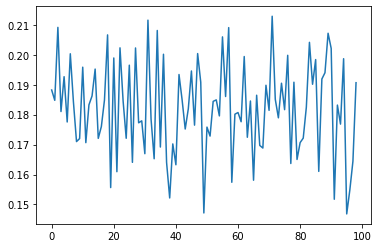

In [11]:
import seaborn
print(values[0])
#loss_values = [i[0] for i in loss_values]
loss = []
for i in values:
    loss.append(float(i))
print(np.arange(len(values)))
seaborn.lineplot(np.arange(len(values)), loss)